# チョコボールの内容量を推定する

In [1]:
# ライブラリのインポート
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# プロットする図を綺麗にする
sns.set()

## 仮定
- 実施キャンペーン、時期によって重量は変化しないものと考える

## データを確認する


In [3]:
# データの読み込み
data_raw = pd.read_csv('../data/chocoball_raw.csv')
tastes = pd.read_csv('../data/choco_tastes.csv')

print('data_raw.shape:', data_raw.shape)
print('tastes.shape:', tastes.shape)

data_raw.shape: (281, 9)
tastes.shape: (13, 4)


In [4]:
data_raw.head()

,best_before,buyer,campaign,taste,weight,box_weight,ball_number,silver,gold
0,2018-09-01,A,2,1,31.103,4.776,15,0,0
1,2018-09-01,A,2,1,31.477,4.767,15,0,0
2,2018-09-01,A,2,1,31.615,4.777,15,0,0
3,2018-09-01,A,2,1,31.212,4.785,15,0,0
4,2018-09-01,A,2,1,31.394,4.819,15,0,0


In [5]:
tastes.head()

,id,name,name_en,spec
0,0,ピーナツ,peanut,28
1,1,いちご,strawberry,25
2,2,金のきなこもち,kinako,29
3,3,レモングミ,lemon,29
4,4,甘酒,amazake,22


### データの加工
- 正味重量（weight - box_weight）を作る
- 内容量(spec)をまとめて一つのDataFrameを作る

In [6]:
# 正味重量（weight - box_weight）を作る
data_raw['net_weight'] = data_raw['weight'] - data_raw['box_weight']
data_raw.head()

,best_before,buyer,campaign,taste,weight,box_weight,ball_number,silver,gold,net_weight
0,2018-09-01,A,2,1,31.103,4.776,15,0,0,26.327
1,2018-09-01,A,2,1,31.477,4.767,15,0,0,26.710
2,2018-09-01,A,2,1,31.615,4.777,15,0,0,26.838
3,2018-09-01,A,2,1,31.212,4.785,15,0,0,26.427
4,2018-09-01,A,2,1,31.394,4.819,15,0,0,26.575


In [7]:
# 内容量(spec)をまとめて一つのDataFrameを作る
df_data = pd.merge(data_raw, tastes, left_on=['taste'], right_on=['id'], how='left')
df_data = df_data.loc[:, ['campaign', 'taste', 'name_en', 'angel', 'net_weight', 'spec']]
df_data.head()

/Users/tok41/workspace/seminar_choco/env_sc/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,campaign,taste,name_en,angel,net_weight,spec
0,2,1,strawberry,NaN,26.327,25
1,2,1,strawberry,NaN,26.710,25
2,2,1,strawberry,NaN,26.838,25
3,2,1,strawberry,NaN,26.427,25
4,2,1,strawberry,NaN,26.575,25


### データの基礎統計量確認

#### フレーバー毎の計測データ数

In [8]:
df_data.groupby(['name_en']).count()[['net_weight']].sort_values(by='net_weight', ascending=False)

,net_weight
name_en,
peanut,201
strawberry,18
banana,17
m-caramel,16
amazake,9
pachipachi,9
custard,4
pumpkin,4
ramune,3


データ数にばらつきがあるので、ある程度データ数が多いフレーバーを解析対象とする。

発展的な内容として、統計モデリングの枠組みにおいては、データ数が少ない場合の予測方法はある。
しかし、今回は対象外とする。

In [9]:
df_data_sel = df_data.query('name_en in ["peanut", "strawberry", "banana"]')
grp = df_data_sel.groupby(['name_en'])

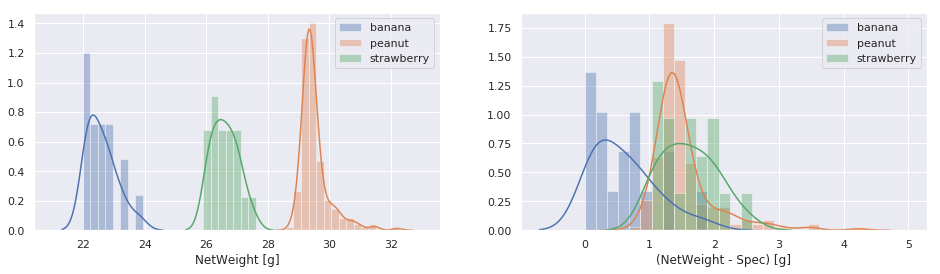

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=np.linspace(21, 33, 50), hist=True, label=key, ax=ax[0])
    sns.distplot((value["net_weight"] - value["spec"]), bins=bins, hist=True, label=key, ax=ax[1])
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()

この図は、左が正味重量のヒストグラム。
右が、マージンのヒストグラム。

## 最尤推定でパラメータを推定する

### モデル設定
- (スライド参照)
- 正味重量は正規分布に従うと仮定
  - 正規分布のパラメータは平均$\mu$と分散$\sigma^2$の二つのパラメータ
  - 平均値$\mu$は仕様上の内容量$spec$にマージン$\alpha$を足したものとする(下記)
    - $\mu = spec + \alpha$
  - チョコボールの購入数（試行数）を$N$とし、データを$X=\{x_1, x_2, \cdots , x_n\}$と表記する
$$
f(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp{\{-\frac{(x-\mu)^2}{2\sigma^2}\}}
$$

### 最尤推定量の計算
- (スライド参照)
- 求めたいパラメータは正味重量の平均$\mu$と分散$\sigma^2$
- 最尤推定では、対数尤度$\log{L(\mu, \sigma^2|X)}$をパラメータ($\mu, \sigma^2$)で偏微分して0となる値を推定値とする
　　- 正規分布のパラメータは2つあるため、偏微分して0となる2つの方程式を解くことになる

$$
L(\mu, \sigma^2|X) = \prod^{N}_{i=1}{f(x|\mu, \sigma^2)} = \prod^{N}_{i=1}{\frac{1}{\sqrt{2\pi\sigma^2}}exp{\{-\frac{(x-\mu)^2}{2\sigma^2}\}}}\\
\log{L(\mu, \sigma^2|X)} = N\log{\frac{1}{\sqrt{2\pi\sigma^2}}} + 
\sum^{N}_{i=1}{(-\frac{(x_i-\mu)^2}{2\sigma^2})}\\
\qquad\qquad\qquad
= -\frac{N}{2}\log{(2\pi\sigma^2)} - \frac{1}{2\sigma^2}\sum^{N}_{i=1}{(x_i-\mu)^2}
$$

$\mu$と$\sigma^2$でそれぞれ偏微分して0と置くと最尤推定量が算出できる。


最初に平均$\mu$から、
$$
\frac{\partial L}{\partial \mu} = -\frac{1}{\sigma^2}\sum{(x_i-\mu)^2} = 0 \\
\mu = \frac{1}{N}\sum{x_i}
$$

次に、分散$\sigma^2$、
$$
\frac{\partial L}{\partial \sigma^2} 
= -\frac{N}{2\sigma^2} + \frac{1}{2(\sigma^2)^2}\sum{(x_i-\mu)^2} = 0 \\
\sigma^2 = \frac{1}{N}\sum{(x_i-\mu)^2}
$$

ということで、長々と数式を展開してきたが、結局はこちらも標本平均と標本分散となる。

In [11]:
# フレーバー毎にグループ分けをする
grp = df_data_sel.groupby(['name_en'])

# 統計量を計算
mu_mse = grp.mean()['net_weight']
mu_mse.name = 'mu'
sig2_mse = grp.var()['net_weight']
sig2_mse.name = 'sig2'

# フレーバーのマスタDataFrameのindexを変更
tastes_spec = tastes.set_index('name_en')
# マージンαの算出
alpha = dict()
for taste, mu in mu_mse.items():
    alpha[taste] = mu - tastes_spec.loc[taste, 'spec']
alpha_s = pd.Series(alpha, name='alpha')

# 結果をまとめる
df_mse = pd.concat([mu_mse, alpha_s, sig2_mse], axis=1)
df_mse

,mu,alpha,sig2
name_en,,,
banana,22.600471,0.600471,0.236885
peanut,29.520338,1.520338,0.228317
strawberry,26.611222,1.611222,0.183120


### 推定値の活用

最尤推定量を計算することができたので、推定結果をデータに当てはめてみる

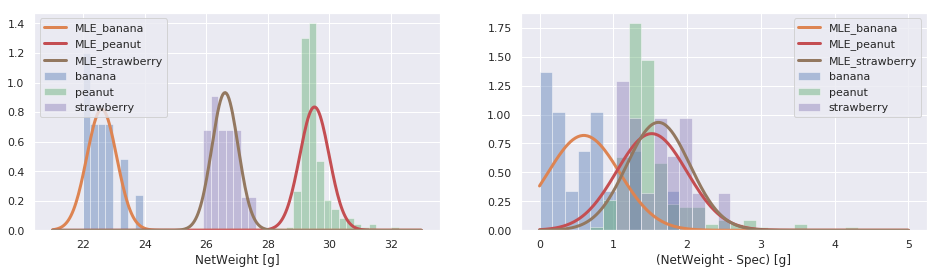

In [12]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins_p = np.linspace(21, 33, 50)
bins_a = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=bins_p, kde=False, hist=True, norm_hist=True, label=key, ax=ax[0])
    x1 = np.linspace(min(bins_p), max(bins_p), 300)
    y1 = stats.norm.pdf(x1, loc=df_mse.loc[key, 'mu'], scale=math.sqrt(df_mse.loc[key, 'sig2']))
    ax[0].plot(x1, y1, lw=3, label='MLE_{}'.format(key))
    
    sns.distplot((value["net_weight"] - value["spec"]), bins=bins_a, kde=False, hist=True, norm_hist=True, label=key, ax=ax[1])
    x2 = np.linspace(min(bins_a), max(bins_a), 300)
    y2 = stats.norm.pdf(x2, loc=df_mse.loc[key, 'alpha'], scale=math.sqrt(df_mse.loc[key, 'sig2']))
    ax[1].plot(x2, y2, lw=3, label='MLE_{}'.format(key))
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()

plt.savefig('net_weight_mle.png')

この結果から、ピーナツとイチゴ味は仕様よりも1.5g程度多く入っているらしいということがわかった。  
また、チョコバナナ味は他の2つと傾向が異なり、仕様に近い重さしか無い(マージンが少ない)こともわかった。

しかし、推定結果は実データと当てはまりが悪い。
モデルを改良する必要がある。
例えば、切断分布を使うようにしたり、（特にイチゴは）階層モデルや混合モデルを考える必要がありそうである。

データ分析はこのように、最もシンプルなモデルでやってみて、
当てはまらないようであれば複雑にしていくというプロセスを踏む必要がある。
最初から複雑なモデルを考えるのは時間もかかるし、無駄になる可能性もある。
また統計モデリングでは、背景を想像しながらモデルを改良することで、説明力が上がる場合がある（想像=仮説、仮説の検証になる）。

## ベイズ推定でパラメータを推定する

### モデル設定
- (スライド資料参照)
- ベイズの式を再度思い出す
    - $p(\theta | x) \propto p(x | \theta)p(\theta)$
    - x : チョコボールの重量データ
    - $\theta$ : 確率分布のパラメータ
    - 尤度$p(x | \theta)$と事前分布$p(\theta)$を設定する必要がある
- 尤度関数
    - 最尤推定と同様に、正規分布を採用
    - $p(x | \theta) = N(\mu, \sigma^2)$
      - なお, $\mu=spec+\alpha$
    - 推定するパラメータは二つ
      - $\alpha$ : 平均のマージン
      - $\sigma^2$ : 分散
- 事前分布
    - 推定するパラメータ毎にそのパラメータの事前分布を設定する必要がある
    - マージン$\alpha$の事前分布には正規分布
      - $p(\alpha) = N(\mu_a, \sigma^2_a)$
    - 分散$\sigma^2$の事前分布には半正規分布
      - $p(\sigma^2) = HalfNormal(sigma^2_b)$

#### 正規分布の形状をみてみよう

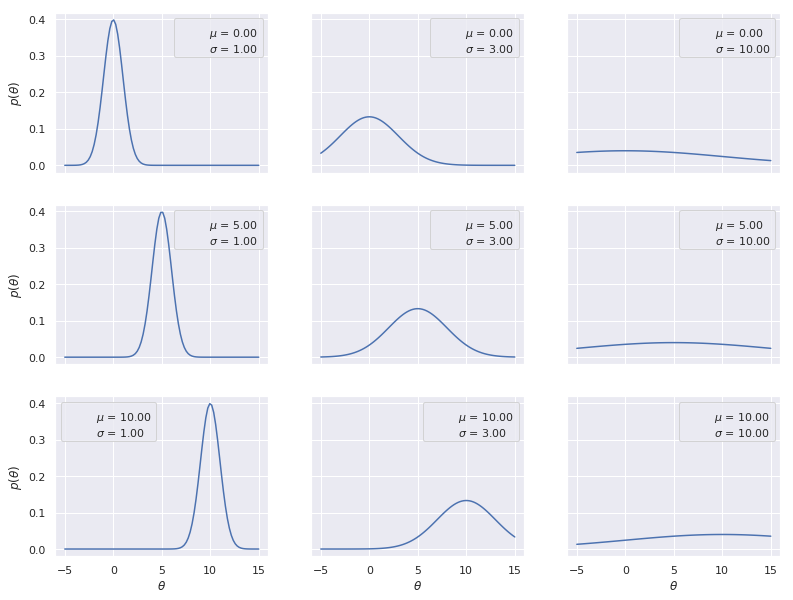

In [13]:
params_mu = [0, 5, 10] # 平均値
params_sig = [1, 3, 10] # 標準偏差

x = np.linspace(-5, 15, 100)

fig = plt.figure(figsize=(13, 10))
ax = fig.subplots(len(params_mu), len(params_sig), sharex=True, sharey=True)
cnt=0
for i in range(len(params_mu)):
    for j in range(len(params_sig)):
        mu = params_mu[i]
        sig = params_sig[j]
        y = stats.norm(mu, sig).pdf(x)
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="$\\mu$ = {:3.2f}\n$\\sigma$ = {:3.2f}".format(mu, sig), alpha=0)
        ax[i, j].legend()
        if i == (len(params_mu)-1):
            ax[i,j].set_xlabel('$\\theta$')
        if j == 0:
            ax[i,j].set_ylabel('$p(\\theta)$')
plt.savefig('norm_dist_var.png')

### 解析的な計算方法(共役事前分布)

エンゼルの出現確率を予測した際に、解析的に計算ができることを示した。  
重量推定のモデルでも同様に計算することができる。

尤度関数は正規分布を利用するので、その共役事前分布を事前分布に選ぶことで解析的に計算ができる。
ここでは計算は省略するが、正規分布の共役事前分布は正規分布である。

### 数値的な計算方法(MCMC)

#### 計算の実行
実際の計算は、エンゼル出現確率の予測と同様にMCMCを利用して、数値的に計算する。

In [14]:
taste = df_data_sel['taste'].values
taste_idx = pd.Categorical(df_data_sel['taste']).codes
tastes_id = tastes.set_index('id')
spec_lst = np.array([tastes_id.loc[i, 'spec'] for i in set(taste)])
print(set(taste))
print(set(taste_idx))
print(spec_lst)

{0, 1, 12}
{0, 1, 2}
[28 25 22]


In [15]:
d_weight = df_data_sel['net_weight'].values
n_sample = 10000

with pm.Model() as model_weight:
    # 事前分布の設定　ｓｈａｐｅを指定することで、複数のパラメータを扱える
    alpha = pm.Normal('alpha', mu=0, sd=20, shape=len(set(taste_idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(taste_idx)))
    # 正規分布のパラメータμを計算(μ自体は確率的に変動しないのでDeterministic宣言)
    mu = pm.Deterministic('mu', spec_lst[taste_idx]+alpha[taste_idx])
    
    weights = pm.Normal('weights', mu=mu, sd=sds[taste_idx], observed=d_weight)
    
    trace = pm.sample(n_sample, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:26<00:00, 1566.01draws/s]


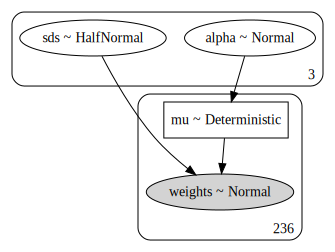

In [16]:
ret = pm.model_to_graphviz(model_weight)
ret.render(filename='model_weight_00', format='png')
ret

### 結果の解釈

推定対象である、正規分布のパラメータ$\mu, \sigma$の事後分布を確認する。
なお、以下の図はchain数（MCMCサンプル系列の数）分の結果が同時に表示されている。
- 左図:パラメータの事後分布
- 右図:パラメータのサンプル系列。ランダムにサンプルされていることが望ましい。

/Users/tok41/workspace/seminar_choco/env_sc/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121521e48>,
      dtype=object)

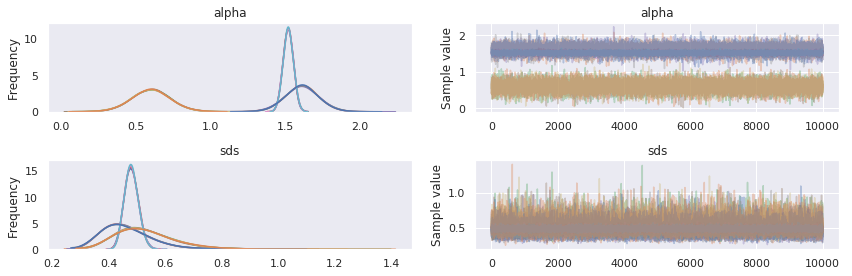

In [17]:
pm.traceplot(trace, varnames=['alpha', 'sds'])

次に、統計量を確認する

In [18]:
pm.summary(trace, varnames=['alpha'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.520451,0.033853,0.000159,1.452775,1.585008,45184.905133,0.999982
alpha__1,1.610997,0.111388,0.000583,1.393758,1.833510,37393.640896,1.000005
alpha__2,0.600525,0.130733,0.000678,0.345566,0.864053,34019.730133,1.000001


- mean:事後分布の期待値
- sd:サンプルの標本標準偏差
- mc_error:サンプリングに起因する誤差の推定値
- hpd_2.5:95%信用区間の下限
- hpd_97.5:95%信用区間の上限
- n_eff:サンプルサイズの効果量
- Rhat:chain間の分散とchain内の分散の比のようなもの。1に近いほど良い。大きい場合は、収束していないchainがある。

chainを全て統合して、事後分布を推定。

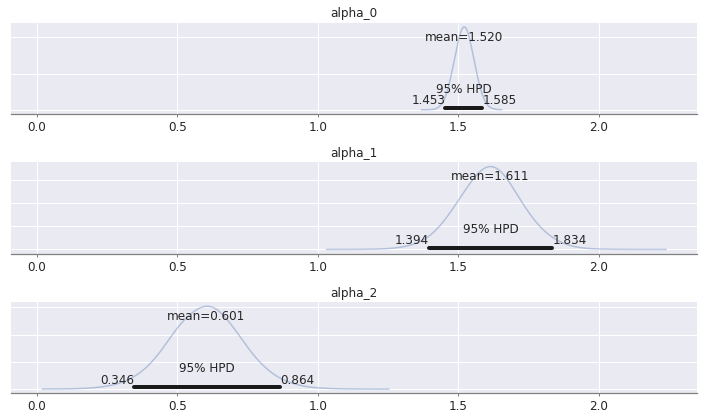

In [19]:
alpha_mse = [df_mse.loc[tastes_id.loc[t, 'name_en'], 'alpha'] 
             for t in set(taste)]

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(3, 1, sharex=True)

pm.plot_posterior(trace, varnames=['alpha'], 
                  kde_plot=True, alpha_level=0.05, ax=ax)
plt.savefig('posterior_weight_diff.png')

この結果から、マージン$\alpha$はフレーバーによって異なることがわかった。
特にチョコバナナ味は、他のフレーバーと比較して、マージン$\alpha$が小さいということがわかった。

## 正味重量を階層ベイズモデルで推定
- マージンは味毎に変えているわけではなく、森永さんがチョコボールを製造する際の思想で設定しているものと想像
    - 仕様に対してalphaグラム多く入れることにしようと方針を決めていると想像
- そのため、データ数が少ないために、マージンに差が出てしまったのではないかとも考えられる


### モデル
- ベイズの式
    - $p(\theta | x) \propto p(x | \theta)p(\theta)$
    - x : チョコボールの重量データ
    - $\theta$ : 確率分布のパラメータ
    - 尤度$p(x | \theta)$と事前分布$p(\theta)$を設定する必要がある
- 尤度関数
    - 最尤推定と同様に、正規分布を採用
    - $p(x | \theta) = N(\mu, \sigma^2)$
      - なお, $\mu=spec+\alpha$
    - 推定するパラメータは二つ
      - $\alpha$ : 平均のマージン
      - $\sigma^2$ : 分散
- 事前分布
    - 推定するパラメータ毎にそのパラメータの事前分布を設定する必要がある
    - マージン$\alpha$の事前分布には正規分布
      - $p(\alpha) = N(\mu_a, \sigma^2_a)$
    - 分散$\sigma^2$の事前分布には半正規分布
      - $p(\sigma^2) = HalfNormal(sigma^2_b)$
- 階層事前分布
    - 事前分布を統括する分布として階層事前分布を仮定
    - マージン$\alpha$の事前分布のパラメータに階層事前分布を設定する
      - $\mu_a$と$\sigma^2_a$のそれぞれに対して事前分布を設定
      - $\sigma^2_b$に対して事前分布を設定

In [20]:
with pm.Model() as comparing_weight_h:
    # 階層事前分布
    am = pm.Normal('am', mu=0, sd=10)
    asd = pm.HalfNormal('asd', sd=10)
    ssd = pm.HalfNormal('ssd', sd=10)
    # 事前分布
    alpha = pm.Normal('alpha', mu=am, sd=asd, shape=len(set(taste_idx)))
    mu = pm.Deterministic('mu', spec_lst[taste_idx]+alpha[taste_idx])
    sds = pm.HalfNormal('sds', sd=ssd, shape=len(set(taste_idx)))
    # 重量モデル
    weights = pm.Normal('weights', mu=mu, sd=sds[taste_idx], observed=d_weight)
    
    trace_wh = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sds, alpha, ssd, asd, am]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 603.68draws/s]
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8891987552893126, but should be close to 0.8. Try to increase the number of tuning steps.
There were 526 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


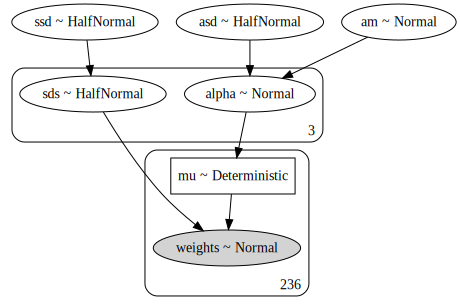

In [21]:
ret = pm.model_to_graphviz(comparing_weight_h)
ret.render(filename='model_weight_01', format='png')
ret

/Users/tok41/workspace/seminar_choco/env_sc/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ad76860>,
      dtype=object)

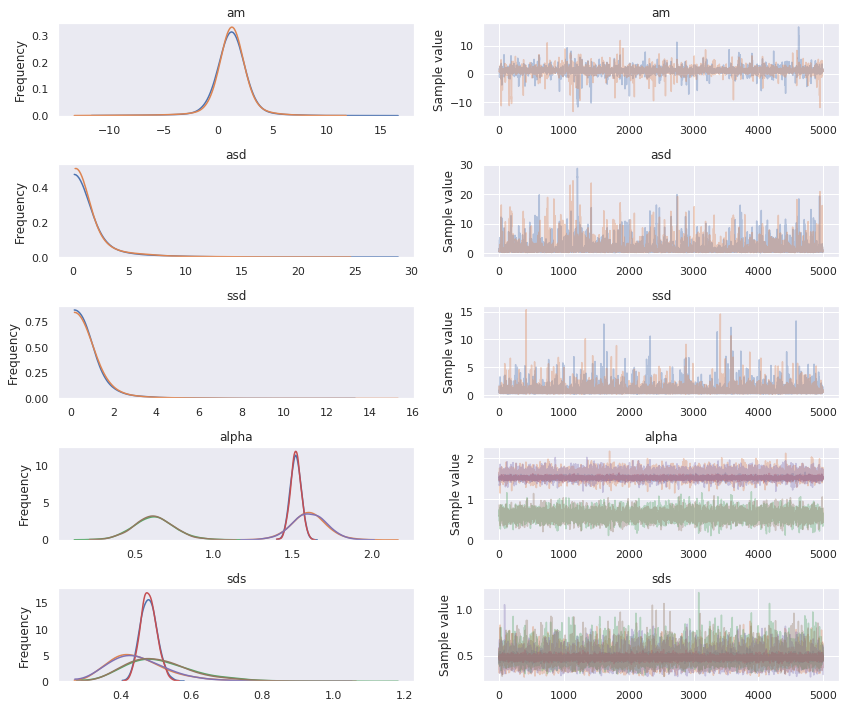

In [22]:
pm.traceplot(trace_wh, varnames=['am', 'asd', 'ssd', 'alpha', 'sds'])

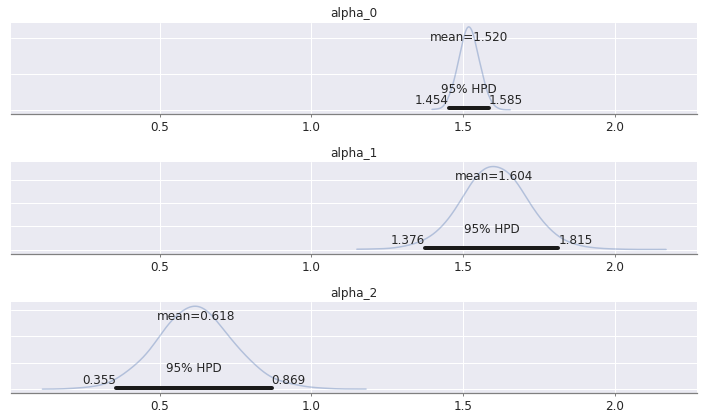

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(3, 1, sharex=True)

pm.plot_posterior(trace_wh, varnames=['alpha'], 
                  kde_plot=True, alpha_level=0.05, ax=ax)
plt.savefig('posterior_weight_diff_hi.png')

- ピーナッツとイチゴのマージンには差が無いように見える
- しかし、チョコバナナは設定が異なっているものと統計的に見える